# Plot rarefaction results 

The following code was used to read in the csv files with the rarefaction results and produce the rarefaction curves shown in the manuscript in Figures 4b and Supplemental Figure 3. 

In [22]:
import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import imp

import pandas as pd
import numpy as np
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [23]:
nonmarshallese_color = '#012E74'
marshallese_color = '#80AAC9'

marshallese_color = '#80AAC9'
non_marshallese_color = '#012E74'

notvaccinated_color = '#CDD2A0'
vaccinated_color =  '#73B387'
unknown_vacc_color = '#0E2D1E'


# vaccinated_color = '#94618E'
# notvaccinated_color =  '#49274A'
# unknown_vacc_color = '#C98474'

under_18_color = '#0E2D1E'
young_adult_color = '#73B387'
over_30_color = '#CDD2A0'

under18notmarshallese_color = "#011D48"
over18notmarshallese_color = '#012E74'
under18marshallese_color = '#80AAC9'
over18marshallese_color = "#CFDFEB"

## Read back in csv files and plot

In [25]:
# read dataframe back in 
marshallese_df = pd.DataFrame.from_csv("../rarefaction-analysis/rarefaction-results/mumps-rarefaction-community-results-2020-03-02.csv",sep="\t")
vacc_df = pd.DataFrame.from_csv("../rarefaction-analysis/rarefaction-results/mumps-rarefaction-vaccination-status-results-2020-03-02.csv", sep="\t")

marshallese_df.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


,trial,number_sequences,introductions,community_status,mean_cluster_size
0,3,9,4,marshallese,2.25
0,4,9,1,marshallese,9.00
0,5,9,4,marshallese,2.25
0,6,9,3,marshallese,3.00
0,7,9,3,marshallese,3.00


In [26]:
print(len(age_with_community_df))
set(age_with_community_df['community_status'].tolist())

1090


{'over18marshallese',
 'over18notmarshallese',
 'under18marshallese',
 'under18notmarshallese'}

In [15]:
def return_df_with_means(df):
    
    # take the mean among the trials 
    df_with_means = pd.DataFrame()

    for c in set(df['community_status'].tolist()):
        for n in set(df['number_sequences'].tolist()):
            x = df[(df['number_sequences'] == n) & (df['community_status'] == c)]

            mean = x['introductions'].mean()
            d = {"number_sequences":[n],"community_status":[c],'mean_introductions':[mean]}

            df_with_means = df_with_means.append(pd.DataFrame.from_dict(d))
            
    return(df_with_means)

In [16]:
marshallese_with_means = return_df_with_means(marshallese_df)
vacc_with_means = return_df_with_means(vacc_df)

vacc_with_means.head()

,number_sequences,community_status,mean_introductions
0,1,over18notmarshallese,1.0
0,2,over18notmarshallese,1.8
0,3,over18notmarshallese,2.5
0,4,over18notmarshallese,3.0
0,5,over18notmarshallese,4.0


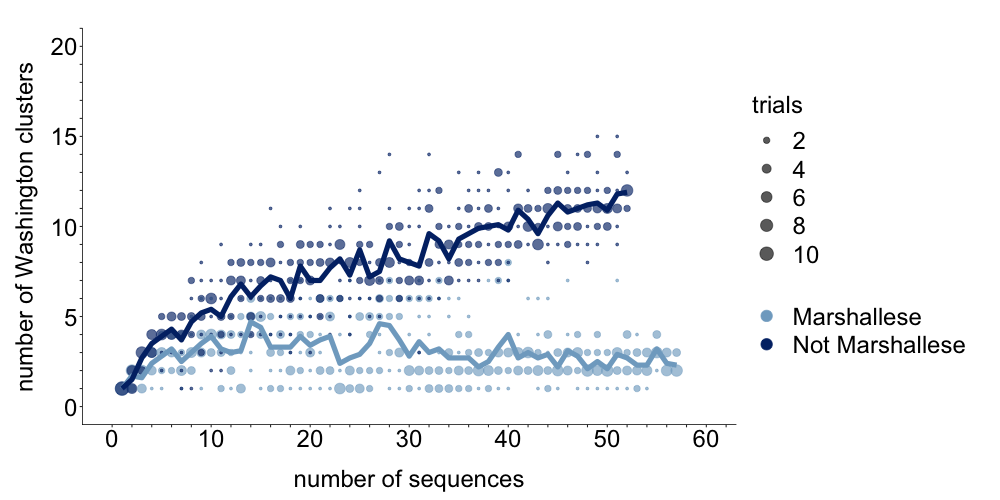

In [47]:
%%R -w 1000 -h 500 -u px -i marshallese_df,marshallese_with_means,marshallese_color,nonmarshallese_color # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

df = marshallese_df
df_with_means = marshallese_with_means

# this code block is necessary for adding blank tick marks
x_max = 60
x_major_ticks_interval = 10
offset = 8
xlabels = seq(0,x_max,x_major_ticks_interval)
x_labels <- c(rbind(xlabels, "","","",""))

y_max = 20
y_major_ticks_interal = 5
ylabels = seq(0,y_max,y_major_ticks_interal)
y_labels <- c(rbind(ylabels, "","","",""))

df$number_sequences = as.numeric(df$number_sequences)
df$introductions = as.numeric(df$introductions)

df_with_means$number_sequences = as.numeric(df_with_means$number_sequences)
df_with_means$mean_introductions = as.numeric(df_with_means$mean_introductions)

p2 <- ggplot(data=df, aes(x=number_sequences, y=introductions, color=community_status, fill=community_status)) + 
    geom_count(alpha=0.65)+
    geom_line(data=df_with_means, aes(x=number_sequences, y=mean_introductions, size=1.75,color=community_status, fill=community_status),alpha=1)+
    labs(x="number of sequences",y="number of Washington clusters")+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_x_continuous(limits=c(0,x_max), breaks=seq(0,x_max+offset,2), labels=c(x_labels))+
    scale_y_continuous(limits=c(0,y_max), breaks=seq(0,y_max+4,1), labels=c(y_labels))+
    scale_color_manual(values=c(marshallese=marshallese_color,nonmarshallese=nonmarshallese_color), labels=c("Marshallese", "Not Marshallese"))+
    scale_fill_manual(values=c('#292166','#8FD086'))+
    scale_size_continuous(breaks=c(2,4,6,8,10))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=24, vjust=6))+
    theme(axis.title.x=element_text(size=24, vjust=-6))+
    theme(axis.text=element_text(size=24, colour="black"))+
    theme(legend.text=element_text(size=24))+
    theme(legend.title=element_text(size=24, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(1, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA)) +
    guides(color = guide_legend(override.aes = list(size = 5, linetype=0, alpha=1), title=NULL))+  #change size of legend glyph
    guides(size = guide_legend(override.aes = list(linetype=0), title="trials"))+
    guides(alpha=FALSE, fill=FALSE)   # turn off alpha and size legends

ggsave("2020-03-04-rarefaction-number-clusters-marshallese-v2.pdf", p2, width = 11, height = 6, path="/Users/lmoncla/Documents/Mumps/paper-and-figure-drafts/individual-PDFs/")
p2

In [21]:
vaccinated_color = '#73B387'
notvaccinated_color =  '#CDD2A0'
unknown_vacc_color = '#0E2D1E'

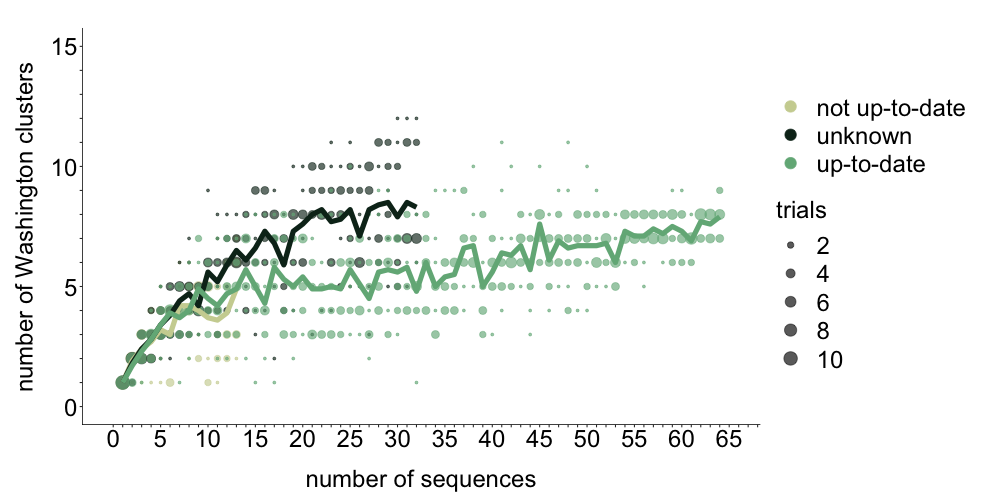

In [21]:
%%R -w 1000 -h 500 -u px -i vacc_df,vacc_with_means,unknown_vacc_color,notvaccinated_color,vaccinated_color # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

df = vacc_df
df_with_means = vacc_with_means

# this code block is necessary for adding blank tick marks
x_max = 65
x_major_ticks_interal = 5
xlabels = seq(0,x_max,x_major_ticks_interal)
x_labels <- c(rbind(xlabels, "","","",""))

y_max = 15
y_major_ticks_interal = 5
ylabels = seq(0,y_max,y_major_ticks_interal)
y_labels <- c(rbind(ylabels, "","","",""))

df$number_sequences = as.numeric(df$number_sequences)
df$introductions = as.numeric(df$introductions)

df_with_means$number_sequences = as.numeric(df_with_means$number_sequences)
df_with_means$mean_introductions = as.numeric(df_with_means$mean_introductions)

p2 <- ggplot(data=df, aes(x=number_sequences, y=introductions, color=community_status, fill=community_status)) + 
    geom_count(alpha=0.65)+
    geom_line(data=df_with_means, aes(x=number_sequences, y=mean_introductions, size=1.75,color=community_status, fill=community_status),alpha=1)+
    labs(x="number of sequences",y="number of Washington clusters")+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_x_continuous(limits=c(0,x_max), breaks=seq(0,x_max+4,1), labels=c(x_labels))+
    scale_y_continuous(limits=c(0,y_max), breaks=seq(0,y_max+4,1), labels=c(y_labels))+
    scale_color_manual(values=c(unknown=unknown_vacc_color,notvaccinated=notvaccinated_color,vaccinated=vaccinated_color), labels=c(unknown="unknown",notvaccinated="not up-to-date",vaccinated="up-to-date"))+
    scale_size_continuous(breaks=c(2,4,6,8,10))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=24, vjust=6))+
    theme(axis.title.x=element_text(size=24, vjust=-6))+
    theme(axis.text=element_text(size=24, colour="black"))+
    theme(legend.text=element_text(size=24))+
    theme(legend.title=element_text(size=24, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(1, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA)) +
    guides(color = guide_legend(override.aes = list(size = 5, linetype=0, alpha=1), title=NULL))+  #change size of legend glyph
    guides(size = guide_legend(override.aes = list(linetype=0), title="trials"))+
    guides(alpha=FALSE, fill=FALSE)   # turn off alpha and size legends

ggsave("2020-08-24-rarefaction-vacc-number-clusters-v2.pdf", p2, width = 12, height = 6, path="/Users/lmoncla/Documents/Mumps/paper-and-figure-drafts/individual-PDFs/")
p2